# Subevent Collaborative Filtering

Diffs from V1:
    Data preprocessing now uses percentiles on the 'Importo' values instead of log-normalization. 
    Calculated for each user based on all his past existing values (NaNs not taken into account).

## Import

In [2]:
import pandas as pd
import surprise as sur
import numpy as np
import matplotlib.pyplot as plt
from time import time
from collections import defaultdict
import statistics
from scipy.stats import percentileofscore
import math

from sklearn import preprocessing as pre
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

## Utils

In [3]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Utilizing total amount

## Read csv

Data obtained with this query

``` mysql
SET TRANSACTION ISOLATION LEVEL READ UNCOMMITTED

select 
    c.IDUtente
    ,pc.Descrizione as Team
    ,sum(c.Importo*cq.MoltiplicatoreRischio) as ImportoxGamba
from
    Scommesse.CouponQuote               cq
    inner join dbo.coupon               c   on c.IDCoupon=cq.IDCoupon 
    inner join dbo.Utenti               u   on c.IDUtente=u.IDUtente
    inner join Palinsenso.Concorrenti   pc  on cq.IDSottoEvento=pc.IDSottoEvento
where 
    c.IDTipoCoupon=1 and u.TestUser=0 and pc.Descrizione <> ''  --Coupon prematch
group by 
    c.IDUtente, pc.Descrizione
order by 
    pc.Descrizione
option (maxdop 8)
```

In [4]:
df = pd.read_csv(r'D:\Projects\ISAI\Data\SubEventsCF\itemCFdata.csv', skiprows=0)

In [4]:
df.head()

,IDUtente,Team,Importo
0,1773,(Mercedes) L.Hamilton,105.8940
1,536,(Racing Point) S.Perez,57.6900
2,15746,07 Vestur,5.1579
3,4734,1 Dezembro,250.0000
4,9295,1 Dezembro,5000.0000


In [5]:
df.shape

(179123, 3)

In [6]:
matrix = df.pivot_table(index='IDUtente', columns='Team', values='Importo')
matrix

Team,(Mercedes) L.Hamilton,(Racing Point) S.Perez,07 Vestur,1 Dezembro,1. FFC Frankfurt Women,1860 Munich,1877 Alemdag,1922 Konyaspor,4 de Julho,9 de Octubre,...,Zira IK,Ziraat Bankasi Ankara,Zlate Moravce,Zlatibor,Znamya Noginsk,Zob Ahan,Zonguldak Komurspor,Zoo Kericho FC,Zrinjski Mostar,Zweigen Kanazawa
IDUtente,,,,,,,,,,,,,,,,,,,,,
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Analysis

Plot histogram of whole population

<AxesSubplot:>

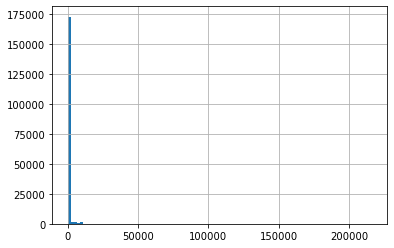

In [198]:
df['Importo'].hist(bins=100)

Showing only one column probably due to skewed data and very big outliers.
Taking the log of all items should solve this.

<AxesSubplot:>

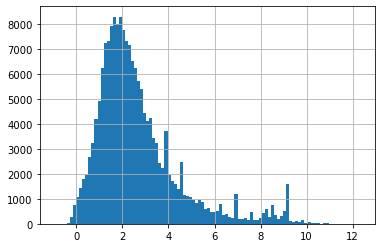

In [199]:
np.log(df['Importo']).hist(bins=100)

Looks like a beta distribution but with a bit of a tail on the right side (convolution?)

Check how many items there are for each team

In [200]:
df.value_counts('Team')

Team
Manchester United          1636
Chelsea                    1424
Manchester City            1389
Arsenal                    1376
Tottenham Hotspur          1337
                           ... 
Inglewood United SC           1
Inegol Bld                    1
Indios de Mayaguez            1
Indiana State Sycamores       1
(Mercedes) L.Hamilton         1
Length: 5916, dtype: int64

## Data pre-processing

We want only teams that have been bet on a significant amount of times

In [64]:
df = pd.read_csv(r'D:\Projects\ISAI\Data\SubEventsCF\itemCFdata.csv', skiprows=0)
#Check for teams that have been bet on less times than arbitrary value
min_inst = 150
team_count = df.value_counts('Team') < min_inst
#Get list of teams to drop
teams_to_drop = team_count.where(team_count==True).dropna().index
#Drop from dataframe
df = df[~df['Team'].isin(teams_to_drop)]

start_time = time()
#Calculate, for each user, the percentile rank for each amount relative to the list of all the amounts wagered
for user in set(df['IDUtente']):
    importi = df.loc[df['IDUtente'] == user, 'Importo']
    df.loc[df['IDUtente'] == user, 'Importo'] = [percentileofscore(importi, a, 'rank')/10 for a in importi]

total_time = time()-start_time
print('Time elapsed in percentile calculation: ', total_time, 's')
print('Average time per user: ', total_time/len(set(df['IDUtente'])), 's')

Time elapsed in percentile calculation:  8.708006858825684 s
Average time per user:  0.0017616845759307472 s


In [71]:
df.value_counts('Team')

Team
Manchester United     1636
Chelsea               1424
Manchester City       1389
Arsenal               1376
Tottenham Hotspur     1337
                      ... 
Bochum                 158
FC Twente Enschede     158
Wazito                 158
Holstein Kiel          156
Portsmouth             150
Length: 196, dtype: int64

## Surprise

In [65]:
#Load df into surprise Dataset
reader = sur.reader.Reader(name=None, line_format=u'user item rating', sep=None, rating_scale=(0, 10), skip_lines=0)
data = Dataset.load_from_df(df, reader)

### Training

In [66]:
time_start = time()

# Build test dataset
trainset = data.build_full_trainset()

#Options for algorithm
sim_options = {'name': 'pearson',
               'user_based': False  #compute similarities between items
               }
#Using K-Nearest Neighbors
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

print('\nTime elapsed:')
print(time() - time_start)

Computing the pearson similarity matrix...
Done computing similarity matrix.

Time elapsed:
0.4640014171600342


## Predict


#### Single user

In [67]:
time_start = time()
predictions = []

for team in set(df['Team']):
    predictions.append(algo.predict(15186, team))

top_n = get_top_n(predictions, n=10)
print('Time elapsed: ', time() - time_start,'s')
top_n

Time elapsed:  0.0220339298248291 s


defaultdict(list,
            {15186: [('Atletico Madrid', 7.776695474855069),
              ('Barcelona', 7.736055115391631),
              ('Paris Saint Germain', 7.707646736588417),
              ('RB Leipzig', 7.379494653384405),
              ('Alaves', 7.295847331272022),
              ('Chelsea', 7.286846935039408),
              ('Real Madrid', 7.217343914078088),
              ('Torino', 7.123421501875254),
              ('Basaksehir', 7.053333810562619),
              ('Sevilla', 7.025521150753565)]})

#### All Users testing

In [69]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

errors = []

for pred in predictions:
    error_sq = (pred[2]-pred[3])**2
    errors.append(error_sq)

mse = sum(errors)/len(errors)
rmse = math.sqrt(mse)

print('MSE: ', mse)
print('RMSE: ', rmse)

MSE:  3.3689495563522196
RMSE:  1.8354698462116503


# Utilizing Total number of bets

``` mysql
SET TRANSACTION ISOLATION LEVEL READ UNCOMMITTED

select 
    c.IDUtente
    ,pc.Descrizione as Team
    ,count(*) as NumeroScommesse
from
    Scommesse.CouponQuote               cq
    inner join dbo.coupon               c   on c.IDCoupon=cq.IDCoupon 
    inner join dbo.Utenti               u   on c.IDUtente=u.IDUtente
    inner join Palinsenso.Concorrenti   pc  on cq.IDSottoEvento=pc.IDSottoEvento
where 
    c.IDTipoCoupon=1 and u.TestUser=0 and pc.Descrizione <> ''  --Coupon prematch
group by 
    c.IDUtente, pc.Descrizione
order by 
    pc.Descrizione
option (maxdop 8)
```

In [10]:
df = pd.read_csv(r'D:\Projects\ISAI\Data\SubEventsCF\numerogiocateCF.csv', skiprows=0)

In [11]:
df.head()

,IDUtente,Team,NumeroGiocate
0,1773,(Mercedes) L.Hamilton,1
1,21249,(Mercedes) V.Bottas,1
2,536,(Racing Point) S.Perez,1
3,15746,07 Vestur,1
4,20820,07 Vestur,1


In [12]:
df.shape

(185273, 3)

In [14]:
matrix = df.pivot_table(index='IDUtente', columns='Team', values='NumeroGiocate')
matrix

Team,(Mercedes) L.Hamilton,(Mercedes) V.Bottas,(Racing Point) S.Perez,07 Vestur,1 Dezembro,1. FFC Frankfurt Women,1860 Munich,1877 Alemdag,1922 Konyaspor,4 de Julho,...,Zlatibor,Znamya Noginsk,Zob Ahan,Zoe Hammond,Zonguldak Komurspor,Zoo Kericho FC,Zrinjski Mostar,Zvezda Ryazan,Zvezda St. Petersburg,Zweigen Kanazawa
IDUtente,,,,,,,,,,,,,,,,,,,,,
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Analysis

Plot histogram of whole population

<AxesSubplot:>

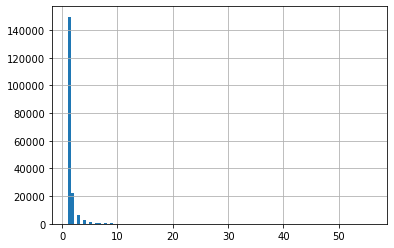

In [15]:
df['NumeroGiocate'].hist(bins=100)

Showing only one column probably due to skewed data and very big outliers.
Taking the log of all items should solve this.

<AxesSubplot:>

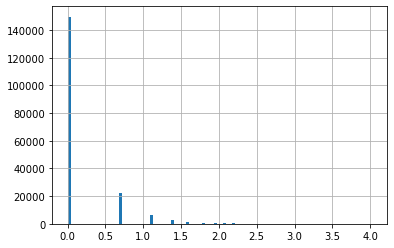

In [16]:
np.log(df['NumeroGiocate']).hist(bins=100)

Looks like a beta distribution but with a bit of a tail on the right side (convolution?)

Check how many items there are for each team

In [17]:
df.value_counts('Team')

Team
Manchester United        1683
Chelsea                  1477
Manchester City          1430
Arsenal                  1415
Tottenham Hotspur        1367
                         ... 
Istres Ouest Provence       1
Istanbul BB                 1
Israel (Women)              1
Iserlohn Roosters           1
(Mercedes) L.Hamilton       1
Length: 6085, dtype: int64

## Data pre-processing

We want only teams that have been bet on a significant amount of times

In [64]:
df = pd.read_csv(r'D:\Projects\ISAI\Data\SubEventsCF\numerogiocateCF.csv', skiprows=0)
#Check for teams that have been bet on less times than arbitrary value
min_inst = 150
team_count = df.value_counts('Team') < min_inst
#Get list of teams to drop
teams_to_drop = team_count.where(team_count==True).dropna().index
#Drop from dataframe
df = df[~df['Team'].isin(teams_to_drop)]

start_time = time()
#Calculate, for each user, the percentile rank for each amount relative to the list of all the amounts wagered
for user in set(df['IDUtente']):
    importi = df.loc[df['IDUtente'] == user, 'NumeroGiocate']
    df.loc[df['IDUtente'] == user, 'NumeroGiocate'] = [percentileofscore(importi, a, 'rank')/10 for a in importi]

total_time = time()-start_time
print('Time elapsed in percentile calculation: ', total_time, 's')
print('Average time per user: ', total_time/len(set(df['IDUtente'])), 's')

Time elapsed in percentile calculation:  8.708006858825684 s
Average time per user:  0.0017616845759307472 s


In [71]:
df.value_counts('Team')

Team
Manchester United     1636
Chelsea               1424
Manchester City       1389
Arsenal               1376
Tottenham Hotspur     1337
                      ... 
Bochum                 158
FC Twente Enschede     158
Wazito                 158
Holstein Kiel          156
Portsmouth             150
Length: 196, dtype: int64

## Surprise

In [18]:
#Load df into surprise Dataset
reader = sur.reader.Reader(name=None, line_format=u'user item rating', sep=None, rating_scale=(0, 10), skip_lines=0)
data = Dataset.load_from_df(df, reader)

### Training

In [19]:
time_start = time()

# Build test dataset
trainset = data.build_full_trainset()

#Options for algorithm
sim_options = {'name': 'pearson',
               'user_based': False  #compute similarities between items
               }
#Using K-Nearest Neighbors
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

print('\nTime elapsed:')
print(time() - time_start)

Computing the pearson similarity matrix...
Done computing similarity matrix.

Time elapsed:
9.012175798416138


## Predict


#### Single user

In [20]:
time_start = time()
predictions = []

for team in set(df['Team']):
    predictions.append(algo.predict(15186, team))

top_n = get_top_n(predictions, n=10)
print('Time elapsed: ', time() - time_start,'s')
top_n

Time elapsed:  1.4091084003448486 s


defaultdict(list,
            {15186: [('RKS Radomiak Radom', 4.0),
              ('Anthony Joshua', 4.0),
              ('Racing Club de Montevideo', 4.0),
              ('Kubrat Pulev', 4.0),
              ('Guillermo Brown', 4.0),
              ('Usti nad Labem', 3.830804040442458),
              ('Simona Halep', 3.0),
              ('San Jose Earthquakes', 3.0),
              ('Sivas 4 Eylul Belediyespor', 3.0),
              ('Aubagne', 3.0)]})

#### All Users testing

In [22]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

errors = []

for pred in predictions:
    error_sq = (pred[2]-pred[3])**2
    errors.append(error_sq)

mse = sum(errors)/len(errors)
rmse = math.sqrt(mse)

print('MSE: ', mse)
print('RMSE: ', rmse)

MSE:  0.13332548750308446
RMSE:  0.3651376281665373
